# SHAP feature selection #
## Code to select feature with combination of LightGBM and SHAP ##

## Parameters cell ##

Parameters are overiddent by papermill when run inside DVC stages



In [1]:
n_folds = 5 # this sets global setting of which how many bootstraps to use
n_hold_out = 1
repeats = 10
importance_type = "split"

debug_local = True #to use local version

In [2]:
from pathlib import Path
import sys
import inspect

#lgb_params["importance_type"] = importance_type

local = (Path("..") / "yspecies").resolve()
if debug_local and local.exists():
  sys.path.insert(0, Path("..").as_posix())
  #sys.path.insert(0, local.as_posix())
  print("extending pathes with local yspecies")
  print(sys.path)
  %load_ext autoreload
  %autoreload 2

extending pathes with local yspecies
['..', '/data/sources/yspecies/notebooks', '/data/miniconda3/envs/yspecies/lib/python38.zip', '/data/miniconda3/envs/yspecies/lib/python3.8', '/data/miniconda3/envs/yspecies/lib/python3.8/lib-dynload', '', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages', '/data/miniconda3/envs/yspecies/lib/python3.8/site-packages/IPython/extensions', '/home/anton/.ipython']


In [3]:
from dataclasses import dataclass, replace
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from typing import *
from yspecies.dataset import *
from yspecies.utils import *
from yspecies.workflow import TupleWith, Repeat, Collect
from yspecies.config import *
from yspecies.preprocess import FeatureSelection, DataExtractor
from yspecies.partition import DataPartitioner, PartitionParameters
from yspecies.models import Metrics
from yspecies.selection import ShapSelector
from yspecies.results import FeatureSummary

In [5]:
import optuna
from optuna import Study, Trial
from optuna import multi_objective
from optuna.multi_objective import trial
from optuna.multi_objective.study import MultiObjectiveStudy
from yspecies.tuning import MultiObjectiveResults

In [6]:
#settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import pprint
pp = pprint.PrettyPrinter(indent=4)

#charts settings
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib auto
plt.ioff()
set_matplotlib_formats('svg')

Using matplotlib backend: agg


### Loading data ###
Let's load data from species/genes/expressions selected by select_samples.py notebook

In [7]:
from pathlib import Path
locations: Locations = Locations("./") if Path("./data").exists() else Locations("../")

In [8]:
from loguru import logger
logger.add(locations.logs / "stage_two_shap_selection.log", rotation="12:00")     # New file is created each day at noon

1

In [9]:
data = ExpressionDataset.from_folder(locations.interim.dir / "stage_2_input")
data

expressions,genes,species,samples,Genes Metadata,Species Metadata
"(408, 142)","(142, 37)",38,408,"(142, 2)","(38, 18)"


## Setting up Features to select ##

In [10]:
not_validated_species = data.min_max_trait("lifespan")
selection = FeatureSelection(
    samples = ["tissue","species"], #samples metadata to include
    species =  [], #species metadata other then Y label to include
    exclude_from_training = ["species"],  #exclude some fields from LightGBM training
    to_predict = "lifespan", #column to predict
    categorical = ["tissue"],
    select_by = "shap",
    importance_type =  importance_type,
    feature_perturbation = "tree_path_dependent",
    not_validated_species = not_validated_species
)
selection

Samples metadata,Species metadata,Genes,Predict label,not_validated species
"['tissue', 'species']",[],all,lifespan,"['Mus_caroli', 'Homo_sapiens']"


### Loading Hyperoptimization studies ###

In [11]:
def load_study(trait: str, study_filename: str = None):
    study_filename = trait if study_filename is None else study_filename
    url = f'sqlite:///' +str((locations.interim.optimization / (study_filename+".sqlite")).absolute())
    print('loading (if exists) study from '+url)
    storage = optuna.storages.RDBStorage(
        url=url
        #engine_kwargs={'check_same_thread': False}
    )
    return optuna.multi_objective.study.create_study(directions=['maximize','minimize','maximize'], storage = storage, study_name = f"{trait}_r2_huber_kendall", load_if_exists = True)

## Setting up SHAP selection pipeline ##

### Deciding on selection parameters (which fields to include, exclude, predict)  ###

In [12]:
partition_params = PartitionParameters(n_folds, n_hold_out, 2,   42)


In [13]:
def make_pipeline(trait: str, study_filename: str = None):
    study = load_study(trait, study_filename)
    if len(study.get_pareto_front_trials())>0 :
        metrics, params = MultiObjectiveResults.from_study(study).best_metrics_params_r2()
        params["verbose"] = -1
        if "early_stopping_round" not in params:
            params["early_stopping_round"] = 10
    else:
        params =  lgb_params = {"bagging_fraction": 0.9522534844058304,
                  "boosting_type": "dart",
                  "objective": "regression",
                  "feature_fraction": 0.42236910941558053,
                  "lambda_l1": 0.020847266580277746,
                  "lambda_l2": 2.8448564854773326,
                  "learning_rate": 0.11484015430016059,
                  "max_depth": 3,
                  "max_leaves": 35,
                  "min_data_in_leaf": 9,
                  "num_iterations": 250,
                  "metrics": ["l1", "l2", "huber"]
                 }
    partition_shap_pipe = Pipeline([
    ("partitioner", DataPartitioner()),
    ('prepare_for_selection', TupleWith(params)),
    ("shap_computation", ShapSelector())
    ]
    )
    repeated_cv =  Repeat(partition_shap_pipe, repeats, lambda x,i: (x[0], replace(x[1], seed = i)))
    return Pipeline(
        [
        ('extractor', DataExtractor()),
        ('prepare_for_partitioning', TupleWith(partition_params)), # to extract the data required for ML from the dataset
        ("partition_shap", repeated_cv),
        ("summarize", Collect(fold=lambda results: FeatureSummary(results)))
        ]
        )

In [14]:
lifespan2 = make_pipeline("lifespan", "lifespan_2")
lifespan2

loading (if exists) study from sqlite:////data/sources/yspecies/notebooks/../data/interim/optimization/lifespan_2.sqlite


create_study is experimental (supported from v1.4.0). The interface can change in the future.
NSGAIIMultiObjectiveSampler is experimental (supported from v1.5.0). The interface can change in the future.
RandomMultiObjectiveSampler is experimental (supported from v1.4.0). The interface can change in the future.
[I 2020-09-12 08:25:27,922] Using an existing study with name 'lifespan_r2_huber_kendall' instead of creating a new one.
MultiObjectiveStudy is experimental (supported from v1.4.0). The interface can change in the future.
FrozenMultiObjectiveTrial is experimental (supported from v1.4.0). The interface can change in the future.


Pipeline(steps=[('extractor', DataExtractor()),
                ('prepare_for_partitioning',
                 TupleWith(parameters=PartitionParameters(n_folds=5, n_hold_out=1, species_in_validation=2, seed=42), map_left=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f021ddf9040>, map_right=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f021ddf9f70>)),
                ('partition_shap',
                 Repeat(transfo...
                 TupleWith(parameters={'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}, map_left=<function TupleWith.<lambda>.<locals>.<lambda> at 0x7f021de1faf0>, map_right=<function TupleWith.<lambda>.<loca

### Lifespan ###

In [15]:
results = lifespan2.fit_transform((data, selection))
results

2020-09-12 08:25:31.369 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 0 =====
2020-09-12 08:25:31.371 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10}
2020-09-12 08:25:31.375 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 0 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 7.77398	valid_0's l2: 175.864	valid_0's huber: 6.64472
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 7.77398	valid_0's l2: 175.864	valid_0's huber: 6.64472


2020-09-12 08:25:31.624 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[202]	valid_0's l1: 3.4117	valid_0's l2: 42.2448	valid_0's huber: 2.72287


2020-09-12 08:25:31.787 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Otolemur_garnettii']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 2.90127	valid_0's l2: 31.6515	valid_0's huber: 2.30509
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 2.90127	valid_0's l2: 31.6515	valid_0's huber: 2.30509


2020-09-12 08:25:31.991 | INFO     | yspecies.selection:fit:82 - SEED: 0 | FOLD: 3 | VALIDATION_SPECIES: ['Macaca_nemestrina', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[190]	valid_0's l1: 3.144	valid_0's l2: 50.5847	valid_0's huber: 2.50873


2020-09-12 08:25:48.472 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9019364233934796, MAE=4.307740936452338, MSE=75.08627920113436, huber=3.5458915903779946)
2020-09-12 08:25:48.481 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 1 =====
2020-09-12 08:25:48.482 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 0}
2020-09-12 08:25:48.485 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 0 | VALIDATION_SPECIES: ['Felis_catus', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[205]	valid_0's l1: 2.94861	valid_0's l2: 19.6651	valid_0's huber: 2.30126


2020-09-12 08:25:48.698 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 1 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Vombatus_ursinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 4.20861	valid_0's l2: 58.9573	valid_0's huber: 3.44597
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 4.20861	valid_0's l2: 58.9573	valid_0's huber: 3.44597


2020-09-12 08:25:48.894 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 2 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Rhinopithecus_bieti']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 2.6937	valid_0's l2: 23.3739	valid_0's huber: 2.09669
Did not meet early stopping. Best iteration is:
[244]	valid_0's l1: 2.69125	valid_0's l2: 23.34	valid_0's huber: 2.09521


2020-09-12 08:25:49.088 | INFO     | yspecies.selection:fit:82 - SEED: 1 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[232]	valid_0's l1: 5.47558	valid_0's l2: 111.951	valid_0's huber: 4.6041


2020-09-12 08:26:05.196 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9237984872918779, MAE=3.8310137468173555, MSE=53.47837108420144, huber=3.1106456817165364)
2020-09-12 08:26:05.205 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 2 =====
2020-09-12 08:26:05.206 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 1}
2020-09-12 08:26:05.210 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ursus_americanus']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[132]	valid_0's l1: 2.74015	valid_0's l2: 18.5285	valid_0's huber: 2.10749


2020-09-12 08:26:05.564 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 1 | VALIDATION_SPECIES: ['Aotus_nancymaae', 'Phascolarctos_cinereus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 4.3216	valid_0's l2: 53.8881	valid_0's huber: 3.54164
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 4.3216	valid_0's l2: 53.8881	valid_0's huber: 3.54164


2020-09-12 08:26:05.768 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 2 | VALIDATION_SPECIES: ['Vombatus_ursinus', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[131]	valid_0's l1: 2.9594	valid_0's l2: 22.0273	valid_0's huber: 2.32489


2020-09-12 08:26:05.887 | INFO     | yspecies.selection:fit:82 - SEED: 2 | FOLD: 3 | VALIDATION_SPECIES: ['Rattus_norvegicus', 'Monodelphis_domestica']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 5.81054	valid_0's l2: 70.1468	valid_0's huber: 4.85628
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 5.80619	valid_0's l2: 70.1019	valid_0's huber: 4.85239


2020-09-12 08:26:19.985 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9317883966164402, MAE=3.9568333441158416, MSE=41.1364642290099, huber=3.2067443042880766)
2020-09-12 08:26:19.991 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 3 =====
2020-09-12 08:26:19.992 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 2}
2020-09-12 08:26:19.996 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 0 | VALIDATION_SPECIES: ['Microcebus_murinus', 'Pan_paniscus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's l1: 3.3752	valid_0's l2: 29.8283	valid_0's huber: 2.69934


2020-09-12 08:26:20.131 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 1 | VALIDATION_SPECIES: ['Ursus_americanus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[216]	valid_0's l1: 6.17861	valid_0's l2: 113.475	valid_0's huber: 5.19361


2020-09-12 08:26:20.304 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 2 | VALIDATION_SPECIES: ['Bos_taurus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.19761	valid_0's l2: 28.0562	valid_0's huber: 2.52827
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 3.19746	valid_0's l2: 28.0655	valid_0's huber: 2.52819


2020-09-12 08:26:20.502 | INFO     | yspecies.selection:fit:82 - SEED: 3 | FOLD: 3 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Mus_musculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[214]	valid_0's l1: 2.53938	valid_0's l2: 31.8108	valid_0's huber: 1.93336


2020-09-12 08:26:34.625 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.931936942149488, MAE=3.822663891269944, MSE=50.794904587768514, huber=3.0874953282463258)
2020-09-12 08:26:34.633 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 4 =====
2020-09-12 08:26:34.634 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 3}
2020-09-12 08:26:34.638 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Pan_troglodytes']
Found `early_stopping_round` in params. Will use it instead of argumen

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.26966	valid_0's l2: 34.0477	valid_0's huber: 2.60876
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.26966	valid_0's l2: 34.0477	valid_0's huber: 2.60876


2020-09-12 08:26:34.846 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 1 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.53368	valid_0's l2: 50.8157	valid_0's huber: 2.85661
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.53368	valid_0's l2: 50.8157	valid_0's huber: 2.85661


2020-09-12 08:26:35.047 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 2 | VALIDATION_SPECIES: ['Heterocephalus_glaber', 'Cavia_aperea']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.7426	valid_0's l2: 32.3077	valid_0's huber: 3.03355
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.7426	valid_0's l2: 32.3077	valid_0's huber: 3.03355


2020-09-12 08:26:35.250 | INFO     | yspecies.selection:fit:82 - SEED: 4 | FOLD: 3 | VALIDATION_SPECIES: ['Pan_paniscus', 'Gorilla_gorilla']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[236]	valid_0's l1: 6.6093	valid_0's l2: 133.571	valid_0's huber: 5.59757


2020-09-12 08:26:53.590 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.915220353141315, MAE=4.288807418027464, MSE=62.685522686963665, huber=3.5242820124209153)
2020-09-12 08:26:53.599 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 5 =====
2020-09-12 08:26:53.600 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 4}
2020-09-12 08:26:53.603 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 0 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Canis_lupus_familiaris']
Found `early_stopping_round` in params. Will use it instead of argum

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[110]	valid_0's l1: 2.5715	valid_0's l2: 17.837	valid_0's huber: 1.9538


2020-09-12 08:26:53.737 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 1 | VALIDATION_SPECIES: ['Ovis_aries', 'Heterocephalus_glaber']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.97757	valid_0's l2: 76.863	valid_0's huber: 3.25035
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.97757	valid_0's l2: 76.863	valid_0's huber: 3.25035


2020-09-12 08:26:53.942 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 4.76892	valid_0's l2: 85.0121	valid_0's huber: 3.96002
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 4.76892	valid_0's l2: 85.0121	valid_0's huber: 3.96002


2020-09-12 08:26:54.137 | INFO     | yspecies.selection:fit:82 - SEED: 5 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_aperea', 'Ailuropoda_melanoleuca']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.94094	valid_0's l2: 53.2548	valid_0's huber: 3.21345
Did not meet early stopping. Best iteration is:
[250]	valid_0's l1: 3.94094	valid_0's l2: 53.2548	valid_0's huber: 3.21345


2020-09-12 08:27:09.136 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9202034871370366, MAE=3.8147328773408766, MSE=58.24172465536334, huber=3.0945533997918617)
2020-09-12 08:27:09.142 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 6 =====
2020-09-12 08:27:09.143 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 5}
2020-09-12 08:27:09.146 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 0 | VALIDATION_SPECIES: ['Rhinolophus_ferrumequinum', 'Heterocephalus_glaber']
Found `early_stopping_round` in params. Will use it inste

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[127]	valid_0's l1: 2.92063	valid_0's l2: 25.1917	valid_0's huber: 2.29181


2020-09-12 08:27:09.271 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 1 | VALIDATION_SPECIES: ['Mus_spicilegus', 'Suricata_suricatta']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.6374	valid_0's l2: 43.365	valid_0's huber: 2.94855
Did not meet early stopping. Best iteration is:
[248]	valid_0's l1: 3.63614	valid_0's l2: 43.3447	valid_0's huber: 2.94694


2020-09-12 08:27:09.538 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 2 | VALIDATION_SPECIES: ['Rhinopithecus_bieti', 'Ovis_aries']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[227]	valid_0's l1: 2.42411	valid_0's l2: 17.4278	valid_0's huber: 1.87242


2020-09-12 08:27:09.742 | INFO     | yspecies.selection:fit:82 - SEED: 6 | FOLD: 3 | VALIDATION_SPECIES: ['Cavia_porcellus', 'Pan_troglodytes']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[188]	valid_0's l1: 3.56243	valid_0's l2: 45.8657	valid_0's huber: 2.86783


2020-09-12 08:27:25.498 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9540411700345359, MAE=3.1358268802340032, MSE=32.95747800839627, huber=2.4959158275103506)
2020-09-12 08:27:25.505 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 7 =====
2020-09-12 08:27:25.507 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 6}
2020-09-12 08:27:25.515 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 0 | VALIDATION_SPECIES: ['Macaca_mulatta', 'Cavia_porcellus']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[168]	valid_0's l1: 2.7704	valid_0's l2: 19.5304	valid_0's huber: 2.15058


2020-09-12 08:27:25.665 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_paniscus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[192]	valid_0's l1: 3.32766	valid_0's l2: 36.0565	valid_0's huber: 2.65881


2020-09-12 08:27:25.816 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 2 | VALIDATION_SPECIES: ['Otolemur_garnettii', 'Ictidomys_tridecemlineatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[192]	valid_0's l1: 3.80327	valid_0's l2: 38.3501	valid_0's huber: 3.09579


2020-09-12 08:27:25.975 | INFO     | yspecies.selection:fit:82 - SEED: 7 | FOLD: 3 | VALIDATION_SPECIES: ['Canis_lupus_familiaris', 'Ursus_americanus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.57651	valid_0's l2: 42.0597	valid_0's huber: 2.8831
Did not meet early stopping. Best iteration is:
[245]	valid_0's l1: 3.57535	valid_0's l2: 42.0299	valid_0's huber: 2.88139


2020-09-12 08:27:41.821 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9528844005265275, MAE=3.369170495079169, MSE=33.99171991639625, huber=2.6952482753781757)
2020-09-12 08:27:41.827 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 8 =====
2020-09-12 08:27:41.828 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 7}
2020-09-12 08:27:41.832 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 0 | VALIDATION_SPECIES: ['Pan_paniscus', 'Suricata_suricatta']
Found `early_stopping_round` in params. Will use it instead of argument


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[102]	valid_0's l1: 2.80066	valid_0's l2: 20.8879	valid_0's huber: 2.18445


2020-09-12 08:27:41.967 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 1 | VALIDATION_SPECIES: ['Macaca_fascicularis', 'Tupaia_belangeri']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[215]	valid_0's l1: 3.16074	valid_0's l2: 32.9194	valid_0's huber: 2.52462


2020-09-12 08:27:42.156 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 2 | VALIDATION_SPECIES: ['Ursus_americanus', 'Capra_hircus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[229]	valid_0's l1: 2.81076	valid_0's l2: 28.1973	valid_0's huber: 2.22252


2020-09-12 08:27:42.369 | INFO     | yspecies.selection:fit:82 - SEED: 8 | FOLD: 3 | VALIDATION_SPECIES: ['Bos_taurus', 'Rhinolophus_ferrumequinum']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[200]	valid_0's l1: 3.12383	valid_0's l2: 41.3724	valid_0's huber: 2.47797


2020-09-12 08:27:56.834 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9563137662216012, MAE=2.974000328781109, MSE=30.844264965867485, huber=2.351429154254367)
2020-09-12 08:27:56.843 | INFO     | yspecies.selection:fit:78 - ===== fitting models with seed 9 =====
2020-09-12 08:27:56.843 | INFO     | yspecies.selection:fit:79 - PARAMETERS:
{'bagging_fraction': 0.757456996980591, 'boosting_type': 'gbdt', 'drop_rate': 0.15938150347995844, 'feature_fraction': 0.41345305892024875, 'lambda_l1': 2.9528782080363634, 'lambda_l2': 2.3536556238167003, 'learning_rate': 0.05373601286514567, 'max_depth': 3, 'max_leaves': 19, 'min_data_in_leaf': 8, 'objective': 'regression', 'metrics': ['l1', 'l2', 'huber'], 'verbose': -1, 'early_stopping_round': 10, 'seed': 8}
2020-09-12 08:27:56.847 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 0 | VALIDATION_SPECIES: ['Ictidomys_tridecemlineatus', 'Aotus_nancymaae']
Found `early_stopping_round` in params. Will use it instead of 

Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
[250]	valid_0's l1: 3.04277	valid_0's l2: 23.2503	valid_0's huber: 2.41006
Did not meet early stopping. Best iteration is:
[249]	valid_0's l1: 3.04277	valid_0's l2: 23.2512	valid_0's huber: 2.41009


2020-09-12 08:27:57.093 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 1 | VALIDATION_SPECIES: ['Pan_troglodytes', 'Oryctolagus_cuniculus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[187]	valid_0's l1: 4.84089	valid_0's l2: 71.9991	valid_0's huber: 4.00457


2020-09-12 08:27:57.307 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 2 | VALIDATION_SPECIES: ['Mesocricetus_auratus', 'Meriones_unguiculatus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[165]	valid_0's l1: 3.77561	valid_0's l2: 37.3916	valid_0's huber: 3.05053


2020-09-12 08:27:57.462 | INFO     | yspecies.selection:fit:82 - SEED: 9 | FOLD: 3 | VALIDATION_SPECIES: ['Gorilla_gorilla', 'Microcebus_murinus']


Training until validation scores don't improve for 10 rounds
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[183]	valid_0's l1: 4.69944	valid_0's l2: 73.7919	valid_0's huber: 3.89208


2020-09-12 08:28:14.693 | INFO     | yspecies.selection:transform:226 - Metrics: 
Metrics(R2=0.9301968743289671, MAE=4.089678200585267, MSE=51.60843451699017, huber=3.3382822269523102)


FeatureSummary(results=[<table border='2'><caption><h3>Feature selection results</h3><caption><tr style='text-align:center'><th>selected</th><th>metrics</th><th>hold out metrics</th></tr><tr><td><div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>symbol</th>
      <th>shap_absolute_sum_to_lifespan</th>
      <th>kendall_tau_to_lifespan</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>ENSG00000204498</th>
      <td>NFKBIL1</td>
      <td>31.500</td>
      <td>-0.611</td>
    </tr>
    <tr>
      <th>ENSG00000165501</th>
      <td>LRR1</td>
      <td>22.500</td>
      <td>0.771</td>
    </tr>
    <tr>
      <th>ENSG00000010219</th>
      <td>DYRK4</td>
      <td>21.750</td>
      <td>0.419</td>
    </tr>
    <tr>
      <th>ENSG00000167515</th>
      <td>TRAPPC2L</td>
      <td>20.000</td>
      <td>-0.373</td>
    </tr>
    <tr>
      <th>ENSG00000132436</th>
      <td>FIGNL1</td>
      <td>18.750</td>
      <td>0.534</td>
    </tr>
    <tr>
      <th>ENSG00000103150</th>
      <td>MLYCD</td>
      <td>17.500</td>
      <td>-0.547</td>
    </tr>
    <tr>
      <th>ENSG00000175806</th>
      <td>MSRA</td>
      <td>17.250</td>
      <td>-0.489</td>
    </tr>
    <tr>
      <th>ENSG00000122952</th>
      <td>ZWINT</td>
      <td>16.750</td>
      <td>-0.560</td>
    </tr>
    <tr>
      <th>ENSG00000213719</th>
      <td>CLIC1</td>
      <td>16.500</td>
      <td>-0.539</td>
    </tr>
    <tr>
      <th>ENSG00000142002</th>
      <td>DPP9</td>
      <td>16.500</td>
      <td>-0.806</td>
    </tr>
    <tr>
      <th>ENSG00000160948</th>
      <td>VPS28</td>
      <td>16.000</td>
      <td>-0.528</td>
    </tr>
    <tr>
      <th>ENSG00000105672</th>
      <td>ETV2</td>
      <td>15.750</td>
      <td>0.654</td>
    </tr>
    <tr>
      <th>ENSG00000137343</th>
      <td>ATAT1</td>
      <td>15.250</td>
      <td>-0.615</td>
    </tr>
    <tr>
      <th>ENSG00000142937</th>
      <td>RPS8</td>
      <td>15.250</td>
      <td>0.715</td>
    </tr>
    <tr>
      <th>ENSG00000102265</th>
      <td>TIMP1</td>
      <td>14.750</td>
      <td>0.526</td>
    </tr>
    <tr>
      <th>ENSG00000165555</th>
      <td>NOXRED1</td>
      <td>14.500</td>
      <td>0.775</td>
    </tr>
    <tr>
      <th>ENSG00000066923</th>
      <td>STAG3</td>
      <td>14.250</td>
      <td>0.433</td>
    </tr>
    <tr>
      <th>ENSG00000023191</th>
      <td>RNH1</td>
      <td>14.000</td>
      <td>-0.590</td>
    </tr>
    <tr>
      <th>ENSG00000171121</th>
      <td>KCNMB3</td>
      <td>14.000</td>
      <td>0.759</td>
    </tr>
    <tr>
      <th>ENSG00000108384</th>
      <td>RAD51C</td>
      <td>13.750</td>
      <td>0.373</td>
    </tr>
    <tr>
      <th>ENSG00000053372</th>
      <td>MRTO4</td>
      <td>13.500</td>
      <td>-0.559</td>
    </tr>
    <tr>
      <th>ENSG00000136942</th>
      <td>RPL35</td>
      <td>13.250</td>
      <td>-0.464</td>
    </tr>
    <tr>
      <th>ENSG00000060762</th>
      <td>MPC1</td>
      <td>13.250</td>
      <td>-0.336</td>
    </tr>
    <tr>
      <th>ENSG00000172531</th>
      <td>PPP1CA</td>
      <td>13.250</td>
      <td>-0.798</td>
    </tr>
    <tr>
      <th>ENSG00000101546</th>
      <td>RBFA</td>
      <td>13.000</td>
      <td>0.286</td>
    </tr>
    <tr>
      <th>ENSG00000164362</th>
      <td>TERT</td>
      <td>12.750</td>
      <td>-0.570</td>
    </tr>
    <tr>
      <th>ENSG00000185880</th>
      <td>TRIM69</td>
      <td>12.750</td>
      <td>-0.099</td>
    </tr>
    <tr>
      <th>ENSG00000184983</th>
      <td>NDUFA6</td>
      <td>12.500</td>
      <td>-0.634</td>
    </tr>
    <tr>
      <th>ENSG00000205323</th>
      <td>SARNP</td>
      <td>12.250</td>
      <td>-0.312</td>
    </tr>
    <t

In [16]:
results.selected.to_csv(locations.output.stage_two / "lifespan.tsv", sep="\t", index_label="reference_gene")

In [17]:
pd.read_csv(locations.output.stage_two / "lifespan.tsv", sep="\t")

,reference_gene,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
0,ENSG00000204498,NFKBIL1,10.000,25.775,-0.564,31.500,-0.611,28.750,-0.397,27.000,-0.583,24.750,-0.487,29.500,-0.580,23.500,-0.535,21.500,-0.620,24.750,-0.607,25.750,-0.668,20.750,-0.549
1,ENSG00000010219,DYRK4,10.000,22.900,0.507,21.750,0.419,20.500,0.504,17.500,0.448,24.250,0.416,19.000,0.569,27.250,0.641,22.750,0.577,20.750,0.539,21.750,0.483,33.500,0.473
2,ENSG00000167515,TRAPPC2L,10.000,21.500,-0.345,20.000,-0.373,19.500,-0.499,22.500,-0.308,24.250,-0.307,24.000,-0.415,18.500,-0.194,23.750,-0.420,24.250,-0.334,18.500,-0.243,19.750,-0.353
3,ENSG00000142002,DPP9,10.000,19.975,-0.806,16.500,-0.806,25.250,-0.828,16.500,-0.810,21.500,-0.792,27.000,-0.797,18.750,-0.798,20.000,-0.784,24.000,-0.814,22.500,-0.787,7.750,-0.842
4,ENSG00000160948,VPS28,10.000,19.675,-0.577,16.000,-0.528,25.750,-0.603,15.000,-0.615,18.500,-0.562,26.500,-0.663,29.000,-0.611,12.750,-0.567,16.000,-0.520,19.750,-0.564,17.500,-0.534
5,ENSG00000165501,LRR1,10.000,19.550,0.719,22.500,0.771,18.750,0.695,15.000,0.784,13.250,0.719,23.250,0.684,26.500,0.743,14.000,0.749,23.500,0.691,11.750,0.709,27.000,0.646
6,ENSG00000105672,ETV2,10.000,17.350,0.679,15.750,0.654,21.250,0.664,17.750,0.679,12.500,0.682,28.250,0.678,14.750,0.695,21.750,0.702,16.750,0.653,9.250,0.699,15.500,0.688
7,ENSG00000023191,RNH1,10.000,16.375,-0.531,14.000,-0.590,17.250,-0.136,16.500,-0.484,14.250,-0.500,15.750,-0.559,19.500,-0.678,16.750,-0.624,17.500,-0.599,18.500,-0.567,13.750,-0.573
8,ENSG00000137343,ATAT1,10.000,16.050,-0.578,15.250,-0.615,14.250,-0.529,20.250,-0.585,18.000,-0.614,14.500,-0.727,12.000,-0.537,12.000,-0.543,17.500,-0.505,15.750,-0.476,21.000,-0.646
9,ENSG00000132436,FIGNL1,10.000,15.550,0.552,18.750,0.534,16.500,0.666,11.750,0.575,19.250,0.610,19.250,0.514,17.000,0.454,9.750,0.507,13.000,0.559,15.000,0.557,15.250,0.543


In [18]:
results.selected.sort_values(by="mean_kendall_tau", ascending=False).head(10)

,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000165555,NOXRED1,10.000,14.750,0.822,14.500,0.775,17.000,0.836,12.750,0.810,14.250,0.840,17.250,0.814,11.000,0.827,16.000,0.849,14.000,0.812,14.750,0.842,16.000,0.819
ENSG00000136436,CALCOCO2,10.000,13.100,0.778,11.750,0.676,11.750,0.819,14.000,0.794,11.750,0.765,17.000,0.778,8.250,0.776,9.500,0.745,11.500,0.786,11.750,0.807,23.750,0.837
ENSG00000138678,GPAT3,10.000,12.275,0.774,9.000,0.846,14.250,0.825,5.250,0.757,8.500,0.754,11.250,0.625,16.250,0.834,15.250,0.795,9.500,0.667,20.000,0.807,13.500,0.828
ENSG00000170835,CEL,10.000,14.950,0.742,5.750,0.771,8.500,0.733,17.000,0.737,16.500,0.764,29.750,0.698,16.500,0.725,12.250,0.750,16.250,0.770,14.250,0.721,12.750,0.748
ENSG00000140398,NEIL1,10.000,11.825,0.736,12.000,0.749,7.500,0.664,11.000,0.794,14.750,0.712,21.000,0.781,11.500,0.830,14.000,0.786,14.500,0.658,5.250,0.724,6.750,0.662
ENSG00000165501,LRR1,10.000,19.550,0.719,22.500,0.771,18.750,0.695,15.000,0.784,13.250,0.719,23.250,0.684,26.500,0.743,14.000,0.749,23.500,0.691,11.750,0.709,27.000,0.646
ENSG00000214941,ZSWIM7,7.000,6.607,0.703,5.500,0.594,6.500,0.818,nan,nan,3.500,0.617,8.750,0.783,9.000,0.677,nan,nan,5.250,0.645,7.750,0.786,nan,nan
ENSG00000108786,HSD17B1,9.000,6.194,0.702,6.000,0.780,9.000,0.686,7.000,0.758,nan,nan,5.750,0.621,6.750,0.703,5.250,0.685,3.750,0.684,6.250,0.684,6.000,0.715
ENSG00000188747,NOXA1,10.000,7.725,0.690,8.750,0.701,8.750,0.696,8.500,0.767,9.000,0.706,7.000,0.696,5.000,0.670,10.500,0.729,8.250,0.692,6.500,0.710,5.000,0.539
ENSG00000105672,ETV2,10.000,17.350,0.679,15.750,0.654,21.250,0.664,17.750,0.679,12.500,0.682,28.250,0.678,14.750,0.695,21.750,0.702,16.750,0.653,9.250,0.699,15.500,0.688


In [27]:
results.selected[results.selected.repeats < 5]

,symbol,repeats,mean_shap,mean_kendall_tau,shap_0,kendall_tau_0,shap_1,kendall_tau_1,shap_2,kendall_tau_2,shap_3,kendall_tau_3,shap_4,kendall_tau_4,shap_5,kendall_tau_5,shap_6,kendall_tau_6,shap_7,kendall_tau_7,shap_8,kendall_tau_8,shap_9,kendall_tau_9
ENSG00000108556,CHRNE,4.000,4.625,-0.312,nan,nan,5.250,-0.449,nan,nan,5.250,-0.312,nan,nan,nan,nan,2.500,-0.315,5.500,-0.171,nan,nan,nan,nan
ENSG00000196419,XRCC6,4.000,4.562,0.669,nan,nan,nan,nan,1.750,0.715,nan,nan,8.500,0.753,nan,nan,2.750,0.551,5.250,0.658,nan,nan,nan,nan
ENSG00000126062,TMEM115,4.000,4.125,-0.108,6.500,0.205,nan,nan,nan,nan,nan,nan,nan,nan,4.750,-0.043,2.500,-0.223,nan,nan,nan,nan,2.750,-0.372
ENSG00000137038,DMAC1,4.000,4.000,-0.068,nan,nan,nan,nan,4.500,-0.102,nan,nan,4.500,0.223,nan,nan,2.750,-0.434,nan,nan,nan,nan,4.250,0.043
ENSG00000166562,SEC11C,4.000,3.688,-0.204,2.250,0.402,5.250,-0.675,nan,nan,2.250,0.156,nan,nan,nan,nan,5.000,-0.700,nan,nan,nan,nan,nan,nan
ENSG00000163528,CHCHD4,4.000,3.312,-0.155,nan,nan,nan,nan,nan,nan,3.250,-0.384,nan,nan,nan,nan,4.750,0.208,2.750,-0.370,nan,nan,2.500,-0.073
ENSG00000171747,LGALS4,4.000,2.500,-0.192,4.500,-0.546,nan,nan,1.250,-0.065,nan,nan,nan,nan,2.500,0.430,1.750,-0.589,nan,nan,nan,nan,nan,nan
ENSG00000134717,BTF3L4,4.000,2.500,-0.243,nan,nan,1.750,-0.601,2.500,0.261,nan,nan,2.250,-0.096,nan,nan,3.500,-0.537,nan,nan,nan,nan,nan,nan
ENSG00000152214,RIT2,4.000,2.250,-0.425,1.500,-0.466,2.000,-0.574,nan,nan,nan,nan,3.500,-0.503,2.000,-0.158,nan,nan,nan,nan,nan,nan,nan,nan
ENSG00000079246,XRCC5,3.000,7.167,0.037,7.000,0.075,11.250,-0.294,nan,nan,nan,nan,nan,nan,nan,nan,3.250,0.330,nan,nan,nan,nan,nan,nan


In [65]:
upd_shap = np.mean([np.nan_to_num(sh, nan = 0.0) for sh in results.shap_values],axis=0)
upd_shap[0].shape

(143,)

In [74]:
summary_stage_two_plot_path = locations.output.dir / "plots" / "stage_two_summary_lifespan.svg"
summary_stage_two = results._plot_(upd_shap, max_display=40, plot_size=0.4, save=summary_stage_two_plot_path)

In [23]:
results.metrics_average

Metrics(R2=0.9318320300841268, MAE=3.759046811870337, MSE=49.08251638520913, huber=3.045048780093692)

In [22]:
results.validation_metrics["R^2"].mean()

0.9421900844742765

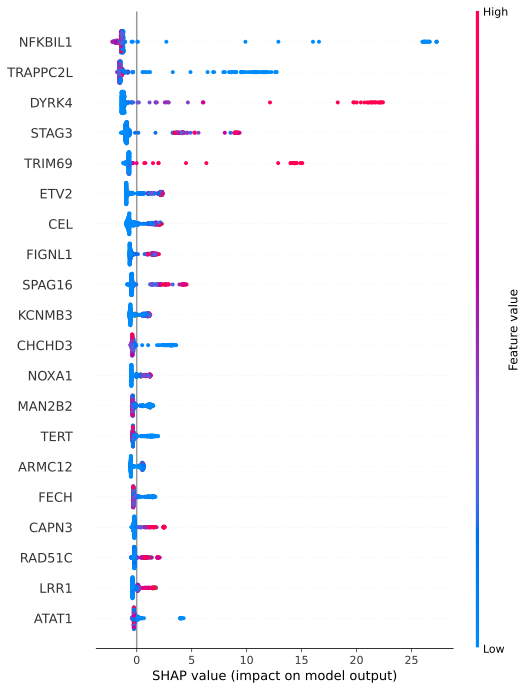

In [50]:
results.plot(max_display=200, plot_size=0.5)